<a href="https://colab.research.google.com/github/mhabib80/Misc.-Data-Analysis-ML/blob/master/Vendors_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

In [ ]:
os.chdir('/content/drive/MyDrive/Work/Roebbelen')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Work/Roebbelen/11.03.21_Master Subcontractor_Vendor Database.csv')
df.head()

,Number,Bid Package,Company,First Name,Last Name,Invalid Email,Email,Vendor,Phone,Office Phone,Cell,Street,City,State,Zip,Labor Type,Enterprise Type,Tags,Qualification Status
0,1,Permit Expeditor,Unknown Company,NaN,NaN,NaN,projects@sfcodes.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Archaeological Monitoring Services,Tremaine & Associates Inc.,Kim,Tremaine,NaN,ktremaine@tremaine.us,NaN,+1 707-333-5288,NaN,NaN,1220 Smith Court,Dixon,CA,95620,NaN,Disadvantaged Business Enterprise (DBE),BP01 Archaeological Monitoring Services,NaN
2,1,"Building Materials, Supplies and Aids",Level Construction Supply,Jon,Kenney,NaN,jon@levelsupply.com,NaN,+1 415-822-4334,+1 415-822-4334,NaN,1220 Fitzgerald Avenue,San Francisco,CA,94124,NaN,"Women Business Enterprise (WBE), Small Busines...","BP01 Building Materials, Supplies and Aids",NaN
3,1,"Building Materials, Supplies and Aids",Ramos Oil,Robert,Feder,NaN,robertf@ramosoil.com,NaN,+1 916-825-2873,(916) 825-2873,NaN,1515 South River Road,West Sacramento,CA,95691,Non-Union,Minority Business Enterprise (MBE),"BP01 Building Materials, Supplies and Aids, BP...",NaN
4,1,"Building Materials, Supplies and Aids",Steeler Construction Supply,NaN,NaN,NaN,sales@steeler.com,NaN,+1 503-231-1100,NaN,NaN,10023 Martin Luther King Junior Way,Seattle,WA,98178,"Union, Non-Union",NaN,"BP01 Building Materials, Supplies and Aids",NaN


# Data Info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14061 entries, 0 to 14060
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number                14061 non-null  int64  
 1   Bid Package           14061 non-null  object 
 2   Company               14061 non-null  object 
 3   First Name            12312 non-null  object 
 4   Last Name             12212 non-null  object 
 5   Invalid Email         713 non-null    object 
 6   Email                 14061 non-null  object 
 7   Vendor                28 non-null     object 
 8   Phone                 11896 non-null  object 
 9   Office Phone          7325 non-null   object 
 10  Cell                  3875 non-null   object 
 11  Street                11807 non-null  object 
 12  City                  13185 non-null  object 
 13  State                 13195 non-null  object 
 14  Zip                   12451 non-null  object 
 15  Labor Type         

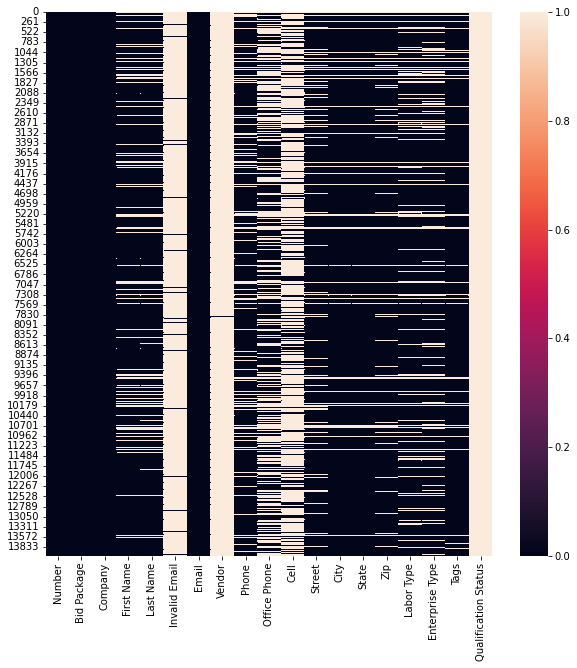

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df.isnull(), ax = ax);

# Tags

In [ ]:
#Extracting tags: ['SMUD SEED Contractor','ISNetWorld Approved','AT&T Prequalified', 'AT&T Prequalified (FOC Only)', 'SoCal','IBEW 1245']

df['Tags'] = df['Tags'].apply(lambda x : re.split(r', (?=BP\d\d|ISNet|SMUD|AT&T|SoCal|IBEW)', str(x)))
tags = df['Tags'].explode().dropna().unique()
tags = [tag for tag in tags if 'BP' not in tag]
tags.remove('nan')
tags

['SMUD SEED Contractor',
 'ISNetWorld Approved',
 'AT&T Prequalified',
 'SoCal',
 'IBEW 1245',
 'AT&T Prequalified (FOC Only)']

In [ ]:
#Create a column for each tag

for tag in tags:
  df[tag] = df.Tags.apply(lambda x : 'Y' if tag in x else 'N')
df.head()

,Number,Bid Package,Company,First Name,Last Name,Invalid Email,Email,Vendor,Phone,Office Phone,Cell,Street,City,State,Zip,Labor Type,Enterprise Type,Tags,Qualification Status,SMUD SEED Contractor,ISNetWorld Approved,AT&T Prequalified,SoCal,IBEW 1245,AT&T Prequalified (FOC Only)
0,1,Permit Expeditor,Unknown Company,NaN,NaN,NaN,projects@sfcodes.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[nan],NaN,N,N,N,N,N,N
1,1,Archaeological Monitoring Services,Tremaine & Associates Inc.,Kim,Tremaine,NaN,ktremaine@tremaine.us,NaN,+1 707-333-5288,NaN,NaN,1220 Smith Court,Dixon,CA,95620,NaN,Disadvantaged Business Enterprise (DBE),[BP01 Archaeological Monitoring Services],NaN,N,N,N,N,N,N
2,1,"Building Materials, Supplies and Aids",Level Construction Supply,Jon,Kenney,NaN,jon@levelsupply.com,NaN,+1 415-822-4334,+1 415-822-4334,NaN,1220 Fitzgerald Avenue,San Francisco,CA,94124,NaN,"Women Business Enterprise (WBE), Small Busines...","[BP01 Building Materials, Supplies and Aids]",NaN,N,N,N,N,N,N
3,1,"Building Materials, Supplies and Aids",Ramos Oil,Robert,Feder,NaN,robertf@ramosoil.com,NaN,+1 916-825-2873,(916) 825-2873,NaN,1515 South River Road,West Sacramento,CA,95691,Non-Union,Minority Business Enterprise (MBE),"[BP01 Building Materials, Supplies and Aids, B...",NaN,N,N,N,N,N,N
4,1,"Building Materials, Supplies and Aids",Steeler Construction Supply,NaN,NaN,NaN,sales@steeler.com,NaN,+1 503-231-1100,NaN,NaN,10023 Martin Luther King Junior Way,Seattle,WA,98178,"Union, Non-Union",NaN,"[BP01 Building Materials, Supplies and Aids]",NaN,N,N,N,N,N,N


# Enterprise Type

In [ ]:
# Extract distinct Enterprise Types

df['Enterprise Type'] = df['Enterprise Type'].apply(lambda x : str(x).split(', '))
enterprise_types =df['Enterprise Type'].explode().unique().tolist()
enterprise_types = [x for x in enterprise_types if x not in ['nan', 'None', 'Other']]
enterprise_types

['Disadvantaged Business Enterprise (DBE)',
 'Women Business Enterprise (WBE)',
 'Small Business Enterprise (SBE)',
 'Minority Business Enterprise (MBE)',
 'Disabled Veteran Business Enterprise (DVBE)',
 'Historically Underutilized Business (HUB)']

In [ ]:
#Create a Column for each Enterprise Type

for type in enterprise_types:
  df[type] = df['Enterprise Type'].apply(lambda x : 'Y' if type in x else 'N')
df.head()

,Number,Bid Package,Company,First Name,Last Name,Invalid Email,Email,Vendor,Phone,Office Phone,Cell,Street,City,State,Zip,Labor Type,Enterprise Type,Tags,Qualification Status,SMUD SEED Contractor,ISNetWorld Approved,AT&T Prequalified,SoCal,IBEW 1245,AT&T Prequalified (FOC Only),Disadvantaged Business Enterprise (DBE),Women Business Enterprise (WBE),Small Business Enterprise (SBE),Minority Business Enterprise (MBE),Disabled Veteran Business Enterprise (DVBE),Historically Underutilized Business (HUB)
0,1,Permit Expeditor,Unknown Company,NaN,NaN,NaN,projects@sfcodes.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[nan],[nan],NaN,N,N,N,N,N,N,N,N,N,N,N,N
1,1,Archaeological Monitoring Services,Tremaine & Associates Inc.,Kim,Tremaine,NaN,ktremaine@tremaine.us,NaN,+1 707-333-5288,NaN,NaN,1220 Smith Court,Dixon,CA,95620,NaN,[Disadvantaged Business Enterprise (DBE)],[BP01 Archaeological Monitoring Services],NaN,N,N,N,N,N,N,Y,N,N,N,N,N
2,1,"Building Materials, Supplies and Aids",Level Construction Supply,Jon,Kenney,NaN,jon@levelsupply.com,NaN,+1 415-822-4334,+1 415-822-4334,NaN,1220 Fitzgerald Avenue,San Francisco,CA,94124,NaN,"[Women Business Enterprise (WBE), Small Busine...","[BP01 Building Materials, Supplies and Aids]",NaN,N,N,N,N,N,N,N,Y,Y,N,N,N
3,1,"Building Materials, Supplies and Aids",Ramos Oil,Robert,Feder,NaN,robertf@ramosoil.com,NaN,+1 916-825-2873,(916) 825-2873,NaN,1515 South River Road,West Sacramento,CA,95691,Non-Union,[Minority Business Enterprise (MBE)],"[BP01 Building Materials, Supplies and Aids, B...",NaN,N,N,N,N,N,N,N,N,N,Y,N,N
4,1,"Building Materials, Supplies and Aids",Steeler Construction Supply,NaN,NaN,NaN,sales@steeler.com,NaN,+1 503-231-1100,NaN,NaN,10023 Martin Luther King Junior Way,Seattle,WA,98178,"Union, Non-Union",[nan],"[BP01 Building Materials, Supplies and Aids]",NaN,N,N,N,N,N,N,N,N,N,N,N,N


In [ ]:
df.iloc[1817, -6:] #check row 1819 in spreadsheet

Disadvantaged Business Enterprise (DBE)        Y
Women Business Enterprise (WBE)                N
Small Business Enterprise (SBE)                Y
Minority Business Enterprise (MBE)             Y
Disabled Veteran Business Enterprise (DVBE)    N
Historically Underutilized Business (HUB)      N
Name: 1817, dtype: object

# Labor Type

In [ ]:
#Extract Labor Types
df['Labor Type'] = df['Labor Type'].apply(lambda x : str(x).split(', '))
labor_types = df['Labor Type'].explode().unique().tolist()
labor_types = [x for x in labor_types if x not in ['nan', 'None', 'Other']]
labor_types

['Non-Union', 'Union', 'Prevailing Wages']

In [ ]:
#Create a Column for each Labor Type
for type in labor_types:
  df[type] = df['Labor Type'].apply(lambda x : 'Y' if type in x else 'N')
df.head()

,Number,Bid Package,Company,First Name,Last Name,Invalid Email,Email,Vendor,Phone,Office Phone,Cell,Street,City,State,Zip,Labor Type,Enterprise Type,Tags,Qualification Status,SMUD SEED Contractor,ISNetWorld Approved,AT&T Prequalified,SoCal,IBEW 1245,AT&T Prequalified (FOC Only),Disadvantaged Business Enterprise (DBE),Women Business Enterprise (WBE),Small Business Enterprise (SBE),Minority Business Enterprise (MBE),Disabled Veteran Business Enterprise (DVBE),Historically Underutilized Business (HUB),Non-Union,Union,Prevailing Wages
0,1,Permit Expeditor,Unknown Company,NaN,NaN,NaN,projects@sfcodes.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[nan],[nan],[nan],NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
1,1,Archaeological Monitoring Services,Tremaine & Associates Inc.,Kim,Tremaine,NaN,ktremaine@tremaine.us,NaN,+1 707-333-5288,NaN,NaN,1220 Smith Court,Dixon,CA,95620,[nan],[Disadvantaged Business Enterprise (DBE)],[BP01 Archaeological Monitoring Services],NaN,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N
2,1,"Building Materials, Supplies and Aids",Level Construction Supply,Jon,Kenney,NaN,jon@levelsupply.com,NaN,+1 415-822-4334,+1 415-822-4334,NaN,1220 Fitzgerald Avenue,San Francisco,CA,94124,[nan],"[Women Business Enterprise (WBE), Small Busine...","[BP01 Building Materials, Supplies and Aids]",NaN,N,N,N,N,N,N,N,Y,Y,N,N,N,N,N,N
3,1,"Building Materials, Supplies and Aids",Ramos Oil,Robert,Feder,NaN,robertf@ramosoil.com,NaN,+1 916-825-2873,(916) 825-2873,NaN,1515 South River Road,West Sacramento,CA,95691,[Non-Union],[Minority Business Enterprise (MBE)],"[BP01 Building Materials, Supplies and Aids, B...",NaN,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,N
4,1,"Building Materials, Supplies and Aids",Steeler Construction Supply,NaN,NaN,NaN,sales@steeler.com,NaN,+1 503-231-1100,NaN,NaN,10023 Martin Luther King Junior Way,Seattle,WA,98178,"[Union, Non-Union]",[nan],"[BP01 Building Materials, Supplies and Aids]",NaN,N,N,N,N,N,N,N,N,N,N,N,N,Y,Y,N


In [ ]:
df.iloc[15, :]

Number                                                                       1
Bid Package                                    Commissioning Agent - 3rd Party
Company                                                         Bradley Brooks
First Name                                                             Bradley
Last Name                                                               Brooks
Invalid Email                                                              NaN
Email                                                 bbrooks@cx-solutions.com
Vendor                                                                     NaN
Phone                                                          +1 916-476-3250
Office Phone                                                               NaN
Cell                                                                       NaN
Street                                                      4621 Crestwood Way
City                                                

# Geocoding

##Zip Codes / Country

In [ ]:
df['Zip'] = df['Zip'].fillna('')
def zipcode(x):
  new_zip = x.split('-')[0] #extract first 5 digits from zip codes with the pattern xxxxx-xxxx
  if re.match(r'\d{4+', new_zip): #add a leading zero for 4 digit zip codes
    new_zip = new_zip.zfill(5)
  return new_zip
df['Zip'] = df['Zip'].apply(zipcode)

In [ ]:
canada_zips = [zip for zip in df.Zip.unique() if re.match(r'[A-Z].+', zip)] #canada zip codes start with letters
canada_zips

['N4V', 'T3S', 'L1S 3P8', 'L3M', 'M6K 3E7']

In [ ]:
df['Country'] = df.Zip.apply(lambda x : 'Canada' if x in canada_zips else 'USA') #assign a column for country, for the geocoder to work. All rows are USA except Canada's zip codes

## geocoding

In [ ]:
#create a list of unqiue cities for geocoding
locations = df[['City', 'State', 'Country']].fillna('').apply(lambda x : ', '.join(x) if x['City'] else '', axis=1)
locations_ = locations.unique().tolist()
locations_.remove('')

In [ ]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent='minaa@roebbelen.com')

# errors = []
# d = {}

# for city in locations_:
#   print(city)
#   try:
#     location = geolocator.geocode(city)
#     d[city] = (location.latitude, location.longitude)
#   except: 
#     errors.append(location)
#     continue


# joblib.dump(d, 'city_coordinates') #save the retrieved values

In [ ]:
d = joblib.load('city_coordinates')
df['coordinates'] = locations.map(d)
# df['latitude'], df['longitude'] = df.coordinates.str[0], df.coordinates.str[1] #break the coordinates to latitude and longitude
df[['latitude','longitude']] = df.coordinates.apply(pd.Series)
df.head()

,Number,Bid Package,Company,First Name,Last Name,Invalid Email,Email,Vendor,Phone,Office Phone,Cell,Street,City,State,Zip,Labor Type,Enterprise Type,Tags,Qualification Status,SMUD SEED Contractor,ISNetWorld Approved,AT&T Prequalified,SoCal,IBEW 1245,AT&T Prequalified (FOC Only),Disadvantaged Business Enterprise (DBE),Women Business Enterprise (WBE),Small Business Enterprise (SBE),Minority Business Enterprise (MBE),Disabled Veteran Business Enterprise (DVBE),Historically Underutilized Business (HUB),Non-Union,Union,Prevailing Wages,Country,coordinates,latitude,longitude
0,1,Permit Expeditor,Unknown Company,NaN,NaN,NaN,projects@sfcodes.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[nan],[nan],[nan],NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,USA,NaN,NaN,NaN
1,1,Archaeological Monitoring Services,Tremaine & Associates Inc.,Kim,Tremaine,NaN,ktremaine@tremaine.us,NaN,+1 707-333-5288,NaN,NaN,1220 Smith Court,Dixon,CA,95620,[nan],[Disadvantaged Business Enterprise (DBE)],[BP01 Archaeological Monitoring Services],NaN,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,USA,"(38.4454641, -121.8232958)",38.445464,-121.823296
2,1,"Building Materials, Supplies and Aids",Level Construction Supply,Jon,Kenney,NaN,jon@levelsupply.com,NaN,+1 415-822-4334,+1 415-822-4334,NaN,1220 Fitzgerald Avenue,San Francisco,CA,94124,[nan],"[Women Business Enterprise (WBE), Small Busine...","[BP01 Building Materials, Supplies and Aids]",NaN,N,N,N,N,N,N,N,Y,Y,N,N,N,N,N,N,USA,"(37.7790262, -122.419906)",37.779026,-122.419906
3,1,"Building Materials, Supplies and Aids",Ramos Oil,Robert,Feder,NaN,robertf@ramosoil.com,NaN,+1 916-825-2873,(916) 825-2873,NaN,1515 South River Road,West Sacramento,CA,95691,[Non-Union],[Minority Business Enterprise (MBE)],"[BP01 Building Materials, Supplies and Aids, B...",NaN,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,N,USA,"(38.5804609, -121.530234)",38.580461,-121.530234
4,1,"Building Materials, Supplies and Aids",Steeler Construction Supply,NaN,NaN,NaN,sales@steeler.com,NaN,+1 503-231-1100,NaN,NaN,10023 Martin Luther King Junior Way,Seattle,WA,98178,"[Union, Non-Union]",[nan],"[BP01 Building Materials, Supplies and Aids]",NaN,N,N,N,N,N,N,N,N,N,N,N,N,Y,Y,N,USA,"(47.6038321, -122.3300624)",47.603832,-122.330062


# Name

In [ ]:
#Join First and Last names into one column
Name = df['First Name'] + ' ' + df['Last Name']
df.insert(3, 'Name', Name)

# Drop / Reorder Columns

In [ ]:
#Drop Unnecessary Columns
df.drop(['First Name', 'Last Name', 'Qualification Status', 'Labor Type','Vendor', 'Enterprise Type', 'Tags', 'coordinates'], axis=1, inplace = True)
df.head()

,Number,Bid Package,Company,Name,Invalid Email,Email,Phone,Office Phone,Cell,Street,City,State,Zip,SMUD SEED Contractor,ISNetWorld Approved,AT&T Prequalified,SoCal,IBEW 1245,AT&T Prequalified (FOC Only),Disadvantaged Business Enterprise (DBE),Women Business Enterprise (WBE),Small Business Enterprise (SBE),Minority Business Enterprise (MBE),Disabled Veteran Business Enterprise (DVBE),Historically Underutilized Business (HUB),Non-Union,Union,Prevailing Wages,Country,latitude,longitude
0,1,Permit Expeditor,Unknown Company,NaN,NaN,projects@sfcodes.com,NaN,NaN,NaN,NaN,NaN,NaN,,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,USA,NaN,NaN
1,1,Archaeological Monitoring Services,Tremaine & Associates Inc.,Kim Tremaine,NaN,ktremaine@tremaine.us,+1 707-333-5288,NaN,NaN,1220 Smith Court,Dixon,CA,95620,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,USA,38.445464,-121.823296
2,1,"Building Materials, Supplies and Aids",Level Construction Supply,Jon Kenney,NaN,jon@levelsupply.com,+1 415-822-4334,+1 415-822-4334,NaN,1220 Fitzgerald Avenue,San Francisco,CA,94124,N,N,N,N,N,N,N,Y,Y,N,N,N,N,N,N,USA,37.779026,-122.419906
3,1,"Building Materials, Supplies and Aids",Ramos Oil,Robert Feder,NaN,robertf@ramosoil.com,+1 916-825-2873,(916) 825-2873,NaN,1515 South River Road,West Sacramento,CA,95691,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,N,USA,38.580461,-121.530234
4,1,"Building Materials, Supplies and Aids",Steeler Construction Supply,NaN,NaN,sales@steeler.com,+1 503-231-1100,NaN,NaN,10023 Martin Luther King Junior Way,Seattle,WA,98178,N,N,N,N,N,N,N,N,N,N,N,N,Y,Y,N,USA,47.603832,-122.330062


In [ ]:
#reorder columns
df = df[['Number', 'Bid Package', 'Company', 'Name', 'Invalid Email', 'Email',
       'Phone', 'Office Phone', 'Cell', 'Street', 'City', 'State', 'Zip', 'Country', 'latitude',
       'longitude','SMUD SEED Contractor', 'ISNetWorld Approved', 'AT&T Prequalified',
       'SoCal', 'IBEW 1245', 'AT&T Prequalified (FOC Only)',
       'Disadvantaged Business Enterprise (DBE)',
       'Women Business Enterprise (WBE)', 'Small Business Enterprise (SBE)',
       'Minority Business Enterprise (MBE)',
       'Disabled Veteran Business Enterprise (DVBE)',
       'Historically Underutilized Business (HUB)',  'Non-Union', 'Union', 'Prevailing Wages']]
df.head()

,Number,Bid Package,Company,Name,Invalid Email,Email,Phone,Office Phone,Cell,Street,City,State,Zip,Country,latitude,longitude,SMUD SEED Contractor,ISNetWorld Approved,AT&T Prequalified,SoCal,IBEW 1245,AT&T Prequalified (FOC Only),Disadvantaged Business Enterprise (DBE),Women Business Enterprise (WBE),Small Business Enterprise (SBE),Minority Business Enterprise (MBE),Disabled Veteran Business Enterprise (DVBE),Historically Underutilized Business (HUB),Non-Union,Union,Prevailing Wages
0,1,Permit Expeditor,Unknown Company,NaN,NaN,projects@sfcodes.com,NaN,NaN,NaN,NaN,NaN,NaN,,USA,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
1,1,Archaeological Monitoring Services,Tremaine & Associates Inc.,Kim Tremaine,NaN,ktremaine@tremaine.us,+1 707-333-5288,NaN,NaN,1220 Smith Court,Dixon,CA,95620,USA,38.445464,-121.823296,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N
2,1,"Building Materials, Supplies and Aids",Level Construction Supply,Jon Kenney,NaN,jon@levelsupply.com,+1 415-822-4334,+1 415-822-4334,NaN,1220 Fitzgerald Avenue,San Francisco,CA,94124,USA,37.779026,-122.419906,N,N,N,N,N,N,N,Y,Y,N,N,N,N,N,N
3,1,"Building Materials, Supplies and Aids",Ramos Oil,Robert Feder,NaN,robertf@ramosoil.com,+1 916-825-2873,(916) 825-2873,NaN,1515 South River Road,West Sacramento,CA,95691,USA,38.580461,-121.530234,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,N
4,1,"Building Materials, Supplies and Aids",Steeler Construction Supply,NaN,NaN,sales@steeler.com,+1 503-231-1100,NaN,NaN,10023 Martin Luther King Junior Way,Seattle,WA,98178,USA,47.603832,-122.330062,N,N,N,N,N,N,N,N,N,N,N,N,Y,Y,N


# Export File

In [ ]:
file = df.to_excel('11.03.21_Master Subcontractor Database_MA.xlsx', sheet_name='All')

In [ ]:
contact = [col for col in df.columns if col not in labor_types + enterprise_types + tags]
sheets = [contact, tags, enterprise_types, labor_types]
sheet_names = ['contact', 'tags' ,'enterprise_type', 'labor_types']

In [ ]:
import openpyxl
multi_sheet_file = pd.ExcelWriter('Vendors.xlsx', engine='openpyxl')
for sheet, name in zip(sheets, sheet_names):
  df[sheet].to_excel(multi_sheet_file, sheet_name=name)
  multi_sheet_file.save()

# Verify BI company count

In [ ]:
bi_data = pd.read_csv('data.csv')
bi_data.head()

,BP Number,Bid Package,Company
0,1,Archaeological Monitoring Services,Tremaine & Associates Inc.
1,1,"Building Materials, Supplies and Aids",ABC Insulation
2,1,"Building Materials, Supplies and Aids","Building Supply & Lumber Company (Sacramento, CA)"
3,1,"Building Materials, Supplies and Aids",Level Construction Supply
4,1,"Building Materials, Supplies and Aids","Mission Clay Products, Division of MCP (Oaklan..."


In [ ]:
df_companies = set([company.strip().lower() for company in df.Company.unique()])
bi_companies = set([company.strip().lower() for company in bi_data.Company.unique()])

In [ ]:
df_companies.difference(bi_companies)

set()